In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:

# import scipy
# from datetime import timedelta
# from pylab import rcParams


# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# #from fbprophet import Prophet
# !pip install pmdarima
# from pmdarima import auto_arima

# from statsmodels.tsa.tsatools import lagmat

# from tensorflow import keras

# from sklearn.linear_model import LinearRegression, RidgeCV
# from sklearn.ensemble import RandomForestRegressor, IsolationForest
# from sklearn.metrics import r2_score
# import re

In [18]:
df = pd.read_csv('https://tinyurl.com/tsa-df')
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
def plot_ts(df : pd.DataFrame, site : str, var : str, diff : bool =False):
    '''
    Plots the time-series data for a given site and variable.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    diff : bool, optional
        To use only if `temp` data frame ouptut from `test_stationary()` is being passed
        in place of `df`, by default False.

    Returns
    -------
    None
    '''
    if diff:
        var = var+'_diff'
    temp = df[df['Site'] == site].reset_index(drop=True)
    plt.figure(figsize=(20, 6))
    plt.plot(temp['Date'], temp[var])
    plt.title(f'{var} at {site}')
    plt.xticks(ticks=temp['Date'][temp['Date'].dt.is_month_start],
            labels=temp['Date'][temp['Date'].dt.is_month_start].dt.strftime('%m/%y'))

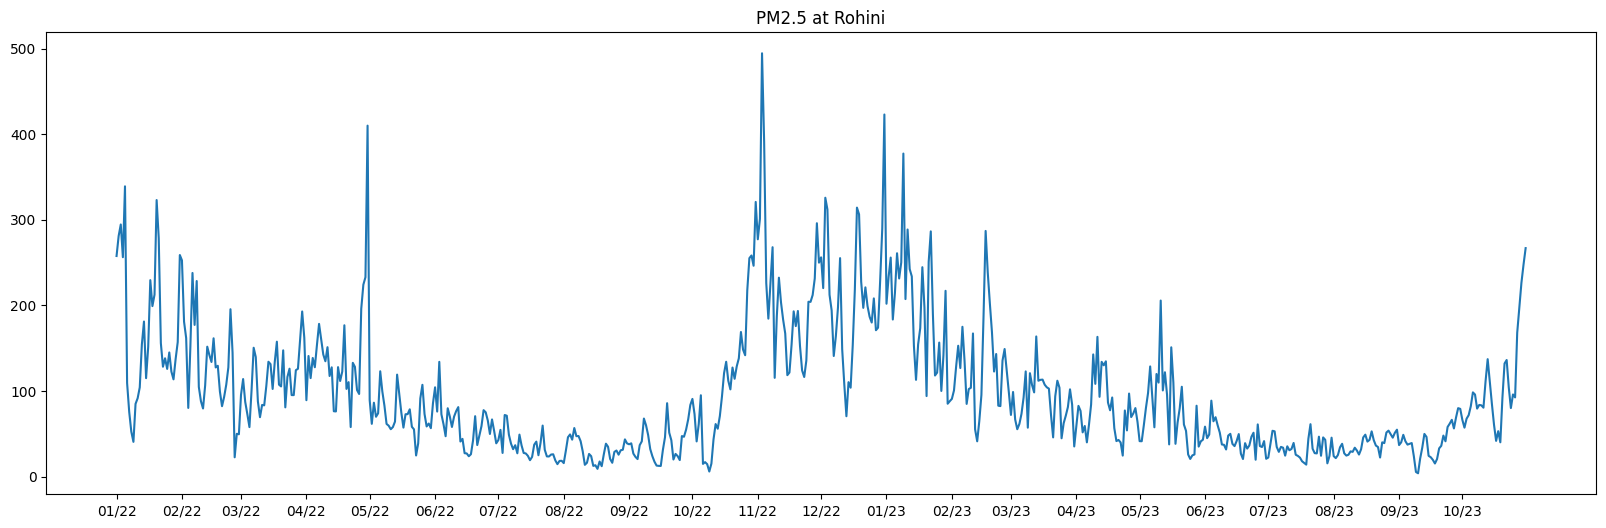

In [20]:
plot_ts(df, 'Rohini', 'PM2.5')

In [21]:
def test_stationarity(df : pd.DataFrame, site : str, var : str, verbose : bool=False):
    '''
    Tests the stationarity of the series using Augmented Dickey-Fuller unit root test

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    verbose : bool, optional
        To be passed True to print some analysis, by default False.

    Returns
    -------
    diff : bool
        Whether differencing was required to make the series stationary
    temp : Pandas DataFrame
        The dataframe containing the time-series data with differenced column
    '''
    temp = df[df['Site'] == site].reset_index(drop=True)
    test = adfuller(temp[var])
    test_stat = round(test[0],3)
    pval = round(test[1],3)
    if pval < 0.05:
        if verbose == True:
            print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
        return 0, temp
    else:
        if verbose == True:
            print(f'{var} at {site} is not stationary with p-value {pval} and test statistic {test_stat}')
            print('Differencing...')
        diff = temp[var].diff().dropna()
        test = adfuller(diff)
        test_stat = round(test[0],3)
        pval = round(test[1],3)
        if pval < 0.05:
            if verbose == True:
                print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
            temp_diff = temp[var].diff().dropna().to_frame(name=var+'_diff')
            temp = temp.join(temp_diff, how='left')
            return 1, temp
        else:
            print('Data is not stationary after differencing')      
            return

In [22]:
def plot_cf(df : pd.DataFrame, var : str, type : str, lags : int = 30, diff : bool=False):
    '''
    Plots the correlogram for a given site and variable.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    type : {'acf', 'pacf'}
        The type of correlogram to plot
    lags : int, optional
        The number of lags to plot, by default 30.
    diff : bool, optional
        To use only if `temp` data frame ouptut from `test_stationary()` is being passed
        in place of `df`, by default False.

    Returns
    -------
    None
    '''
    site = df['Site'].unique()[0]
    df = df.dropna().reset_index(drop=True)
    if diff:
        var = var+'_diff'
    if type == 'pacf':
        fig = tsaplots.plot_pacf(df[var], lags=lags)
        plt.title(f'PACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)
        # return fig
    
    if type == 'acf':
        fig = tsaplots.plot_acf(df[var], lags=lags)
        plt.title(f'ACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)
        # return fig

In [23]:
# for site in df['Site'].unique():
#     print(site, end=': ')
#     st = []
#     for var in ['PM2.5', 'PM10', 'NH3', 'SO2', 'AQI']:
#         st.append(test_stationarity(df,site, var)[0])
#     print(st)

In [24]:
def main(df : pd.DataFrame, site : str, var : str, lags : int=30):
    '''
    Prints the result of `test_stationarity()` and plots the time series (also, differnced, if done)
    and both ACF and PACF correlograms for a given site and variable.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    type : {'acf', 'pacf'}
        The type of correlogram to plot
    lags : int, optional
        The number of lags to plot, by default 30.

    Returns
    -------
    None
    '''
    diff, temp = test_stationarity(df,site, var, verbose=True)
    if diff:
        plot_ts(df, site, var)
        plot_ts(temp, site, var, diff=diff)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)
    else:
        plot_ts(df, site, var)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)

SO2 at Rohini is not stationary with p-value 0.124 and test statistic -2.465
Differencing...
SO2 at Rohini is stationary with p-value 0.0 and test statistic -12.984


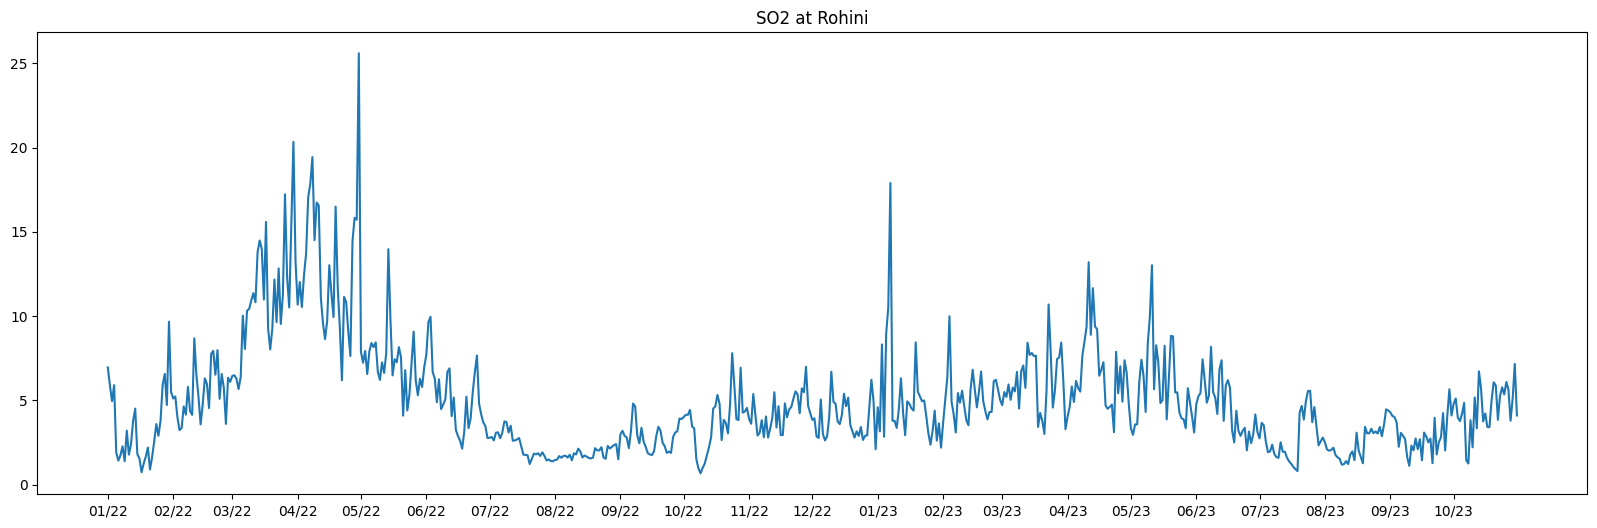

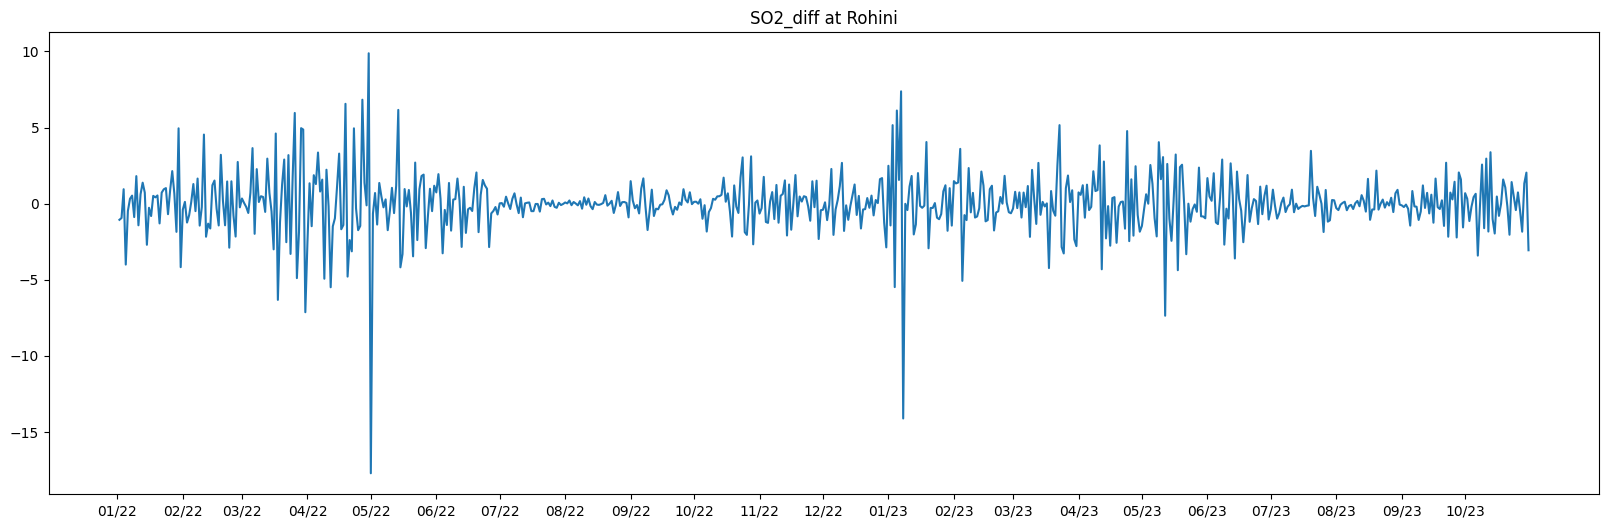

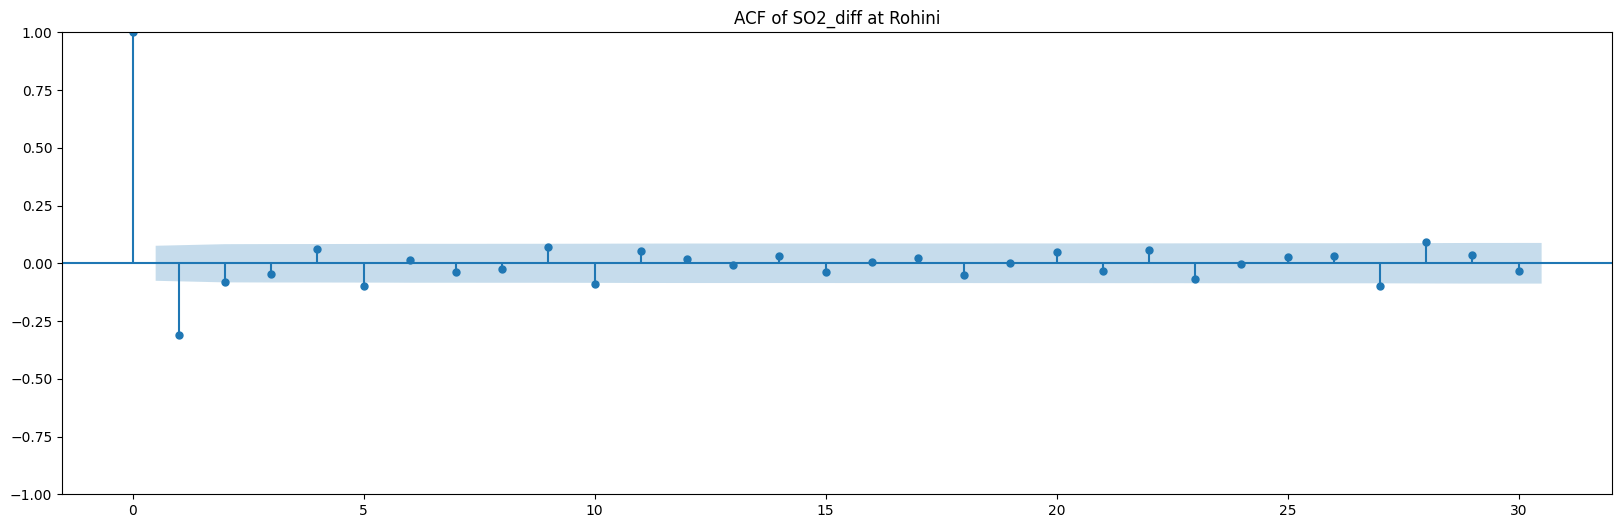

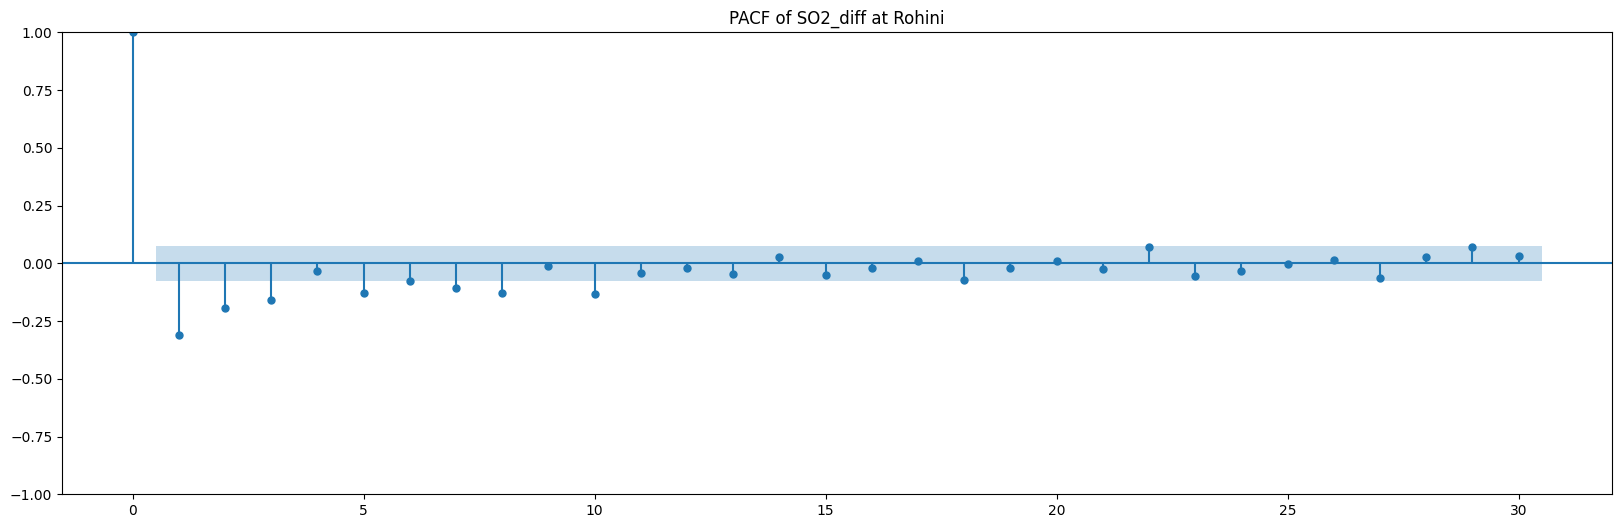

In [25]:
main(df, 'Rohini', 'SO2')

In [26]:
def get_lags(df : pd.DataFrame, site : str, var : str, type : str, lags : int=30, alpha : float=0.05):
    '''
    Returns the significant lags and corresponding p-values for a given site and variable.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    type : {'acf', 'pacf'}
        The type of correlogram to plot
    lags : int, optional
        The number of lags to plot, by default 30.
    alpha : float, optional
        The level of confidence, by default 0.05.

    Returns
    -------
    lag_vals : list
        The significant lags
    cf_lag_vals : list
        The corresponding p-values
    '''
    diff, temp = test_stationarity(df,site, var, verbose=False)
    temp.dropna(inplace=True)
    if diff:
        var = var+'_diff'
    if type == 'acf':
        cf_vals, civals = sm.tsa.acf(temp[var], nlags=lags, alpha=alpha)
        civals = civals - cf_vals.reshape(-1,1)
        lag_vals = []
        cf_lag_vals = []
        for i in range(1,len(cf_vals)):
            if cf_vals[i] > civals[i][1] or cf_vals[i] < civals[i][0]:
                lag_vals.append(i) 
                cf_lag_vals.append(round(cf_vals[i],3))    
        return lag_vals , cf_lag_vals 

    if type == 'pacf':
        cf_vals, civals = sm.tsa.pacf(temp[var], nlags=lags, alpha=alpha)
        civals = civals - cf_vals.reshape(-1,1)
        lag_vals = []
        cf_lag_vals = []
        for i in range(1,len(cf_vals)):
            if cf_vals[i] > civals[i][1] or cf_vals[i] < civals[i][0]:
                lag_vals.append(i)
                cf_lag_vals.append(round(cf_vals[i],3))
        return lag_vals, cf_lag_vals

In [27]:
def is_decay(df : pd.DataFrame, site : str, var : str, type : str, verbose : bool=False):
    '''
    Checks if the correlogram has exponential decay.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    type : {'acf', 'pacf'}
        The type of correlogram to plot
    verbose : bool, optional
        To be passed True to print some analysis, by default False.

    Returns
    -------
    bool :
        True if exponential decay; False if Cuts off
    '''
    l,a = get_lags(df, site, var, type)
    if a[0] < 0.7:
        if verbose == 1:
            print(f'{type} cuts off')
        return False
    for i in range(1,len(l)):
        if abs(a[i]) < 0.7*abs(a[i-1]):
            if verbose == 1:
                print(f'{type} cuts off')
            return False
    if verbose == 1:
        print(f'{type} has exponential decay')
    return True

In [28]:
def get_lags_params(df : pd.DataFrame, site : str, var : str, type : str, num : int=3):
    '''
    Return the lags; to be used to get the lags in case of 'cuts off'.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    type : {'acf', 'pacf'}
        The type of correlogram to plot
    num : int, optional
        Number of lags to return

    Returns
    -------
    l : list
        List of lags
    '''
    l,_ = get_lags(df, site, var, type)
    if len(l) < num:
        return l
    else:
        return l[:num]

In [45]:
def make_decision(df : pd.DataFrame, site : str, var : str, verbose : bool=False):
    '''
    Returns the options for p,d,q parameters to fit.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    verbose : bool, optional
        To be passed True to print some analysis, by default False.

    Returns
    -------
    p : list
        The list of p values
    diff : list
        The list of d values
    q : list
        The list of q values
    '''
    diff, _ = test_stationarity(df,site, var, verbose=False)

    if is_decay(df, site, var, 'pacf') == False and is_decay(df, site, var, 'acf') == False:
        p = [1,2,3]
        q = [1,2,3]
        diff = [diff]
        if verbose == True:
            print('Both ACF and PACF cut off')
            print('Hence an ARMA model should be used')
        return p,diff,q
    
    elif is_decay(df, site, var, 'pacf') and is_decay(df, site, var, 'acf') == False:
        p = [0]
        q = get_lags_params(df, site, var, 'acf')
        diff = [diff]
        if verbose == True:
            print('ACF cuts off and PACF has exponential decay')
            print('Hence an MA model should be used')
        return p,diff,q
    
    elif is_decay(df, site, var, 'pacf') == False and is_decay(df, site, var, 'acf'):
        p = get_lags_params(df, site, var, 'pacf')
        q = [0]
        diff = [diff]
        if verbose == True:
            print('PACF cuts off and ACF has exponential decay')
            print('Hence an AR model should be used')
        return p,diff,q 

In [46]:
# for i in df['Site'].unique():
#     for v in ['PM2.5']:
#         print(i)
#         test_stationarity(df, i, v, verbose=1)  
#         print(make_decision(df, i, v, verbose=1))
#         print()

In [56]:
def fit_arma(df : pd.DataFrame, site : str, var : str, verbose : bool=True):
    '''
    Tries ARMA models to the time series data using order suggestions from `make_decision()`.
    Fits the best model based on AIC.

    Parameters
    ----------
    df : Pandas DataFrame
        The dataframe containing the time-series data
    site : string
        The name of the site
    var : string
        The name of pollutant variable
    verbose : bool, optional
        To be passed True to print some analysis, by default True.

    Returns
    -------
    result :
        The result of the fitted model
    '''
    p_vals, d_vals, q_vals = make_decision(df, site, var, verbose=1)
    print('Trying out the following combinations:')
    print('p:',p_vals)
    print('d:',d_vals)
    print('q:',q_vals)
    best_aic, best_bic, best_order, best_model = float("inf"), float("inf"), None, None
    for p in p_vals:
        for q in q_vals:
            for d in d_vals:
                model = SARIMAX(df[var], order=(p,d,q))
                result = model.fit()
                if result.aic < best_aic and result.bic < best_bic:
                    best_aic, best_bic, best_order, best_model = result.aic, result.bic, (p, d, q), result
    print(f'Best model: ARIMA{best_order} with AIC: {round(best_aic,3)} and BIC: {round(best_bic,3)}')
    if verbose == True:
        best_model.summary()
    return best_model, best_order

PM2.5 at Rohini is stationary with p-value 0.012 and test statistic -3.367
PACF cuts off and ACF has exponential decay
Hence an AR model should be used
PACF cuts off and ACF has exponential decay
Hence an AR model should be used
Trying out the following combinations:
p: [1, 2, 3]
d: [0]
q: [0]
Best model: ARIMA(3, 0, 0) with AIC: 277737.469 and BIC: 277770.443


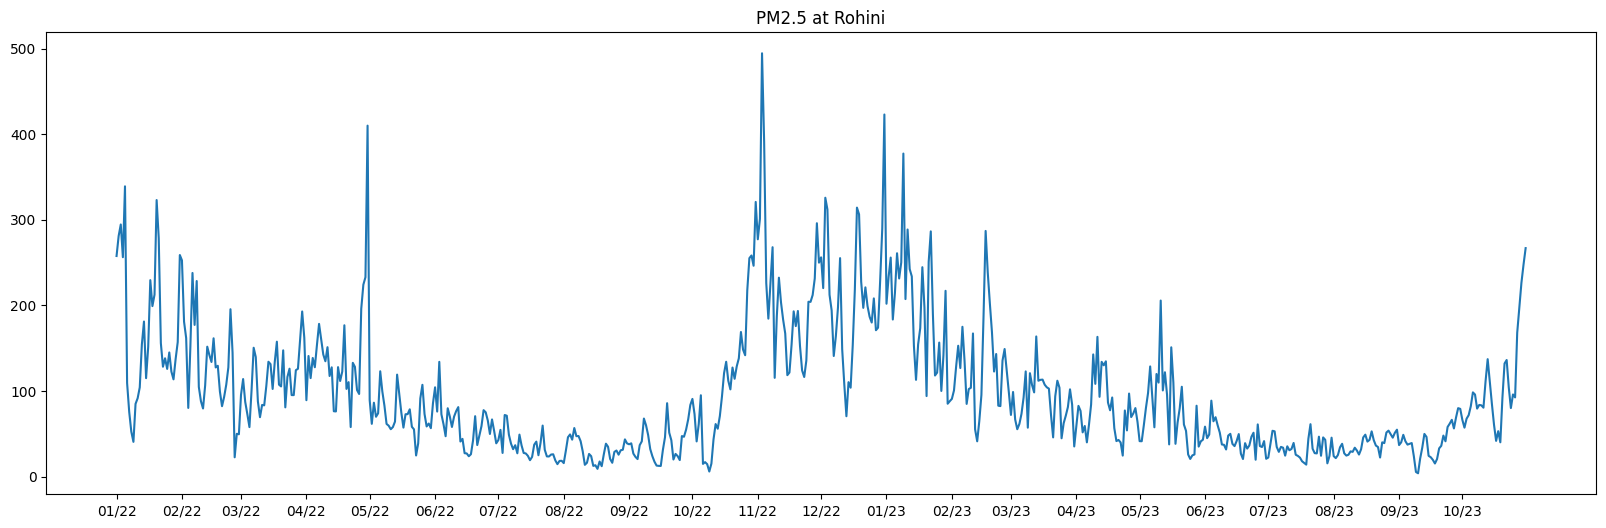

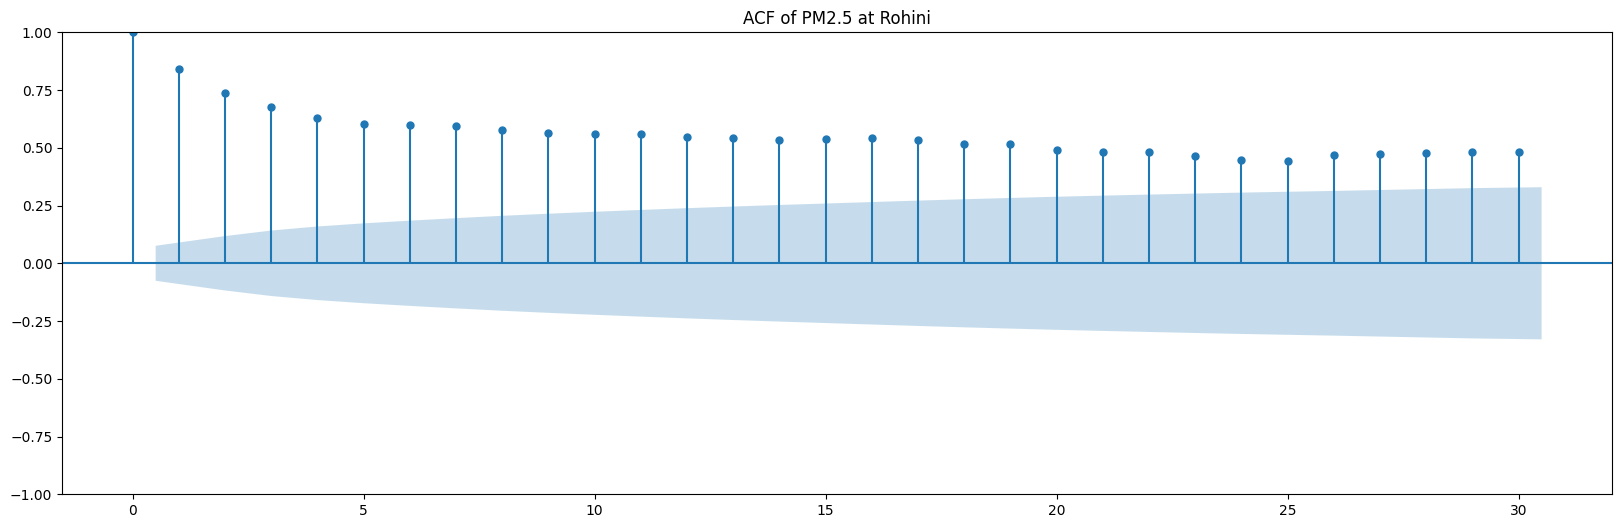

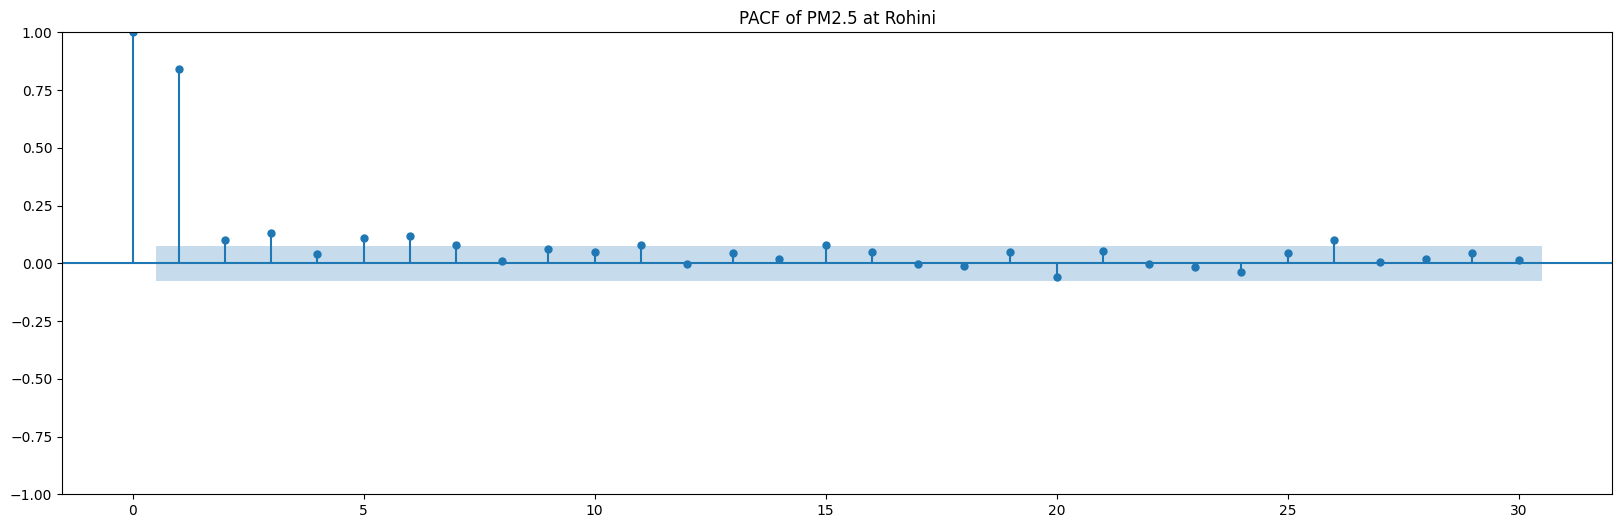

In [57]:
site = 'Rohini'
var = 'PM2.5'
main(df, site, var, lags=30)
make_decision(df, site, var, verbose=True)
best = fit_arma(df, site, var, verbose=False)